<div style="text-align: center; font-size: 40px;">
    <b>Final Project</b>
    <br>
    Exploration of the Computer dataset
    <br>
    
</div>

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

Let's test our library code on the `computer` dataset from the UCR classification dataset available here : 
- https://www.timeseriesclassification.com/description.php?Dataset=Computers    

In [ ]:
def plot_distribution(train_proba, test_proba): 
    fig, ax = plt.subplots()
    ax.hist(train_proba, bins=20, label="baseline", alpha=0.7, density=True)
    ax.hist(test_proba, bins=20,  label="anomaly", alpha=0.7, density=True)
    ax.set_title('Distribution of probility score, train and test set')
    ax.set_xlabel("score")
    ax.legend()
    plt.show()

# I) A first look at our data

## SAX Transformation

Since the data is actually a dataset of continuous sequences, we will need transform it into a discreet sequence using the SAX method. Thankfully, we implemented a `SAX`class in opur library, that given an `.arff` file, transform it into a labelised dataset of discreet sequences. There are two modes to this class, `local` and `global`, where `global`utilizes the values from the whole dataset of timeseries to assign the breakpoints for the sax method, whereas `local` only compute these values on the timeserie that is being transformed into a sylmbolic serie.

In [ ]:
from utils import SAX, PlotPCA

filename = "../Data/Computers/Computers_TRAIN.arff"

saxer = SAX(word_size=5, alphabet_size=5, mode="local")
continuous_timeseries = saxer.ingest_pickle(filename)
dataset = saxer.transform()

You can visualize a few of the sequences here, by adjusting the paramter of the `display_sequence` function.

In [1]:
saxer.display_sequence(140)

NameError: name 'saxer' is not defined

Now let us parse the dataset into a baseline set, an anomalous set, and let's create baseline validation set to see the anomaly score assigned to baseline data.

In [5]:
baseline = dataset.loc[dataset["label"] == 1]
anomaly = dataset.loc[dataset["label"] == 2]

print(f"length category 1 : {len(anomaly)} : length category 2 : {len(baseline)}")

baseline_train = baseline.sample(frac=0.8, random_state=42)
baseline_validation = baseline.drop(baseline_train.index)

anomaly_sample = anomaly.sample(frac=0.8, random_state=42)

baseline_validation = baseline_validation["sequence"].values
baseline_train = baseline_train["sequence"].values
anomaly_sample = anomaly_sample["sequence"].values

length category 1 : 125 : length category 2 : 125


## How did SAX transform the underlying data ? 

In this section, we will see if the SAX transformation did not completly destroy the separation between the two categories of our signal, which would explain the poor performances of our algorithm later. 

{np.str_('D'): 0, np.str_('E'): 1, np.str_('C'): 2, np.str_('B'): 3, np.str_('A'): 4}


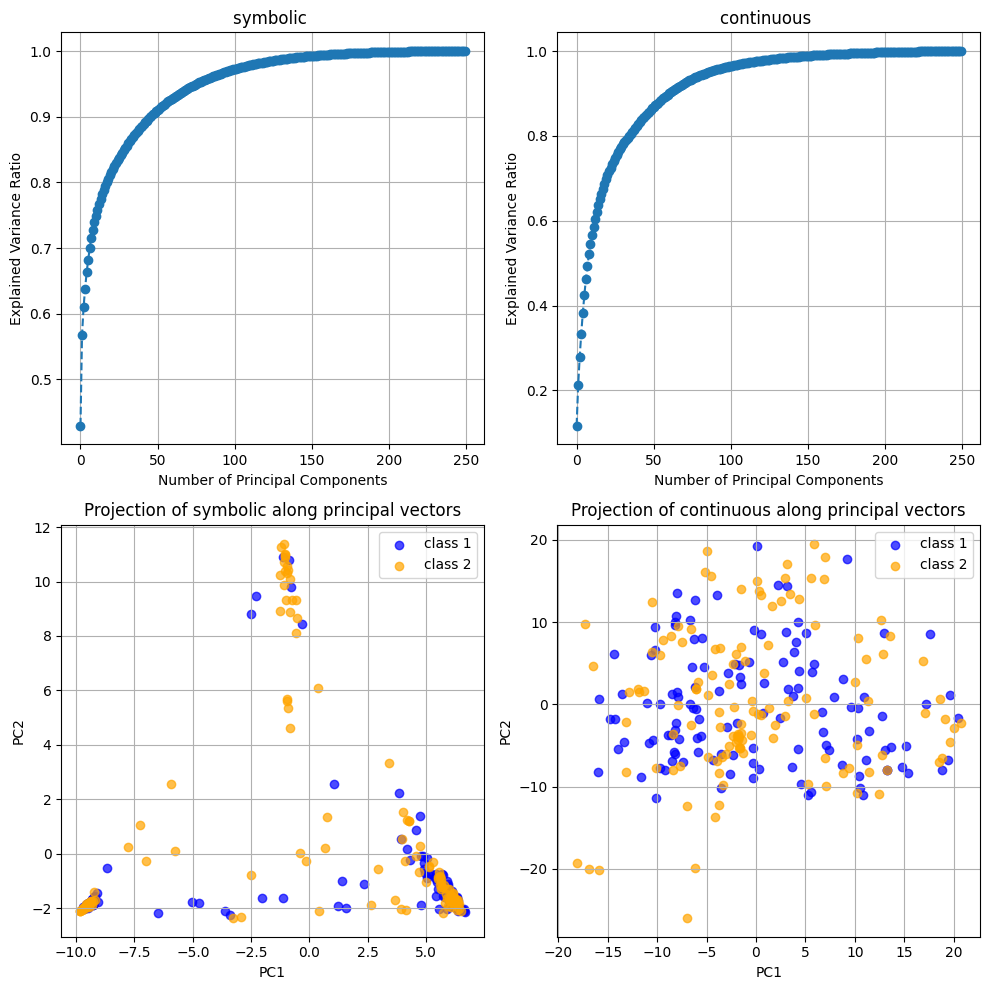

In [46]:
plotter = PlotPCA()
plotter.pca(dataset)
plotter.display(figsize=(10, 10))

# I) Kernel Based Techniques :

In [8]:
from KernelBased import KnearestKernel, MedoidsKernel, nLCS

knearest_dad = KnearestKernel(nLCS)
knearest_dad.train(baseline_train)

train_proba = knearest_dad.predict_proba(baseline_validation)
test_proba = knearest_dad.predict_proba(anomaly_sample)

Now let us plot the distribution of the train score and the test score to see if anomalies can be infered. 

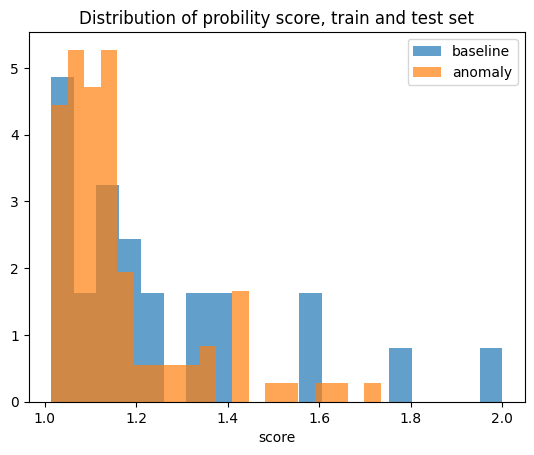

In [9]:
fig, ax = plt.subplots()
ax.hist(train_proba, bins=20, label="baseline", alpha=0.7, density=True)
ax.hist(test_proba, bins=20,  label="anomaly", alpha=0.7, density=True)
ax.set_title('Distribution of probility score, train and test set')
ax.set_xlabel("score")
ax.legend()

Now let us see if the faster K-medoids implementation yield any better result.

In [10]:
kmedoids_dad = MedoidsKernel(nLCS)
kmedoids_dad.train(baseline_train)

train_proba = kmedoids_dad.predict_proba(baseline_validation)
test_proba = kmedoids_dad.predict_proba(anomaly_sample)

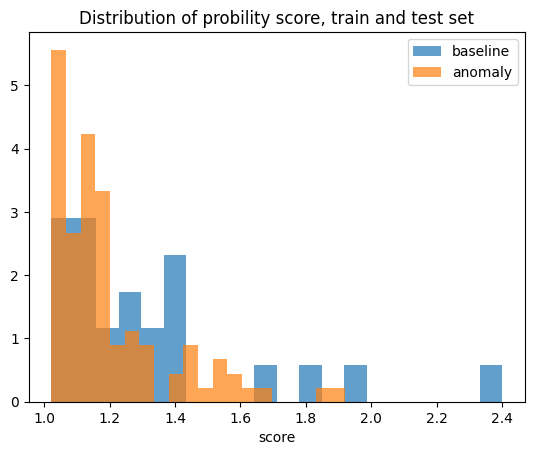

In [11]:
plot_distribution(train_proba, test_proba)

There is no significant difference between the distribution of probability score for the anomalous set or the baseline set, therefore the kernel based method can not work on this dataset. This is especially clear since the distribution of the continuous sequences are also very similar to one another.

# III) Window Based Techniques :

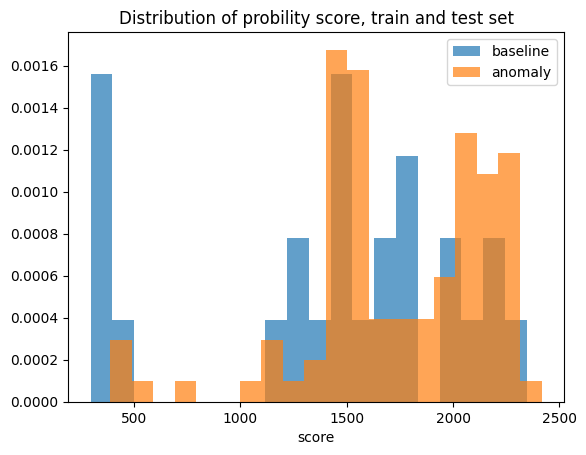

In [12]:
from WindowBased import Lookahead, NormalDictionary, UnsupervisedSVM

lookahead = Lookahead(window_length=10)
lookahead.train(baseline_train)

train_proba = lookahead.predict_proba(baseline_validation)
test_proba = lookahead.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

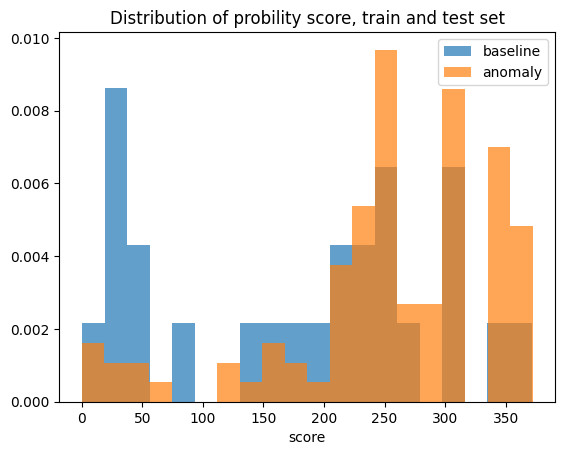

In [13]:
normal_dic = NormalDictionary(window_length=10)
normal_dic.train(baseline_train)

train_proba = normal_dic.predict_proba(baseline_validation)
test_proba = normal_dic.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

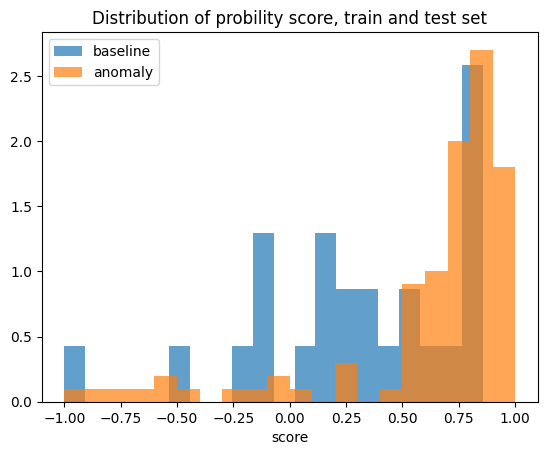

In [14]:
svm = UnsupervisedSVM(window_length=5)
svm.train(baseline_train)

train_proba = svm.predict_proba(baseline_validation)
test_proba = svm.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)

# IV) Markov Based Techniques : 

In [15]:
from MarkovBased import FixedMarkovianBased, SparseMarkovRIPPER, SparseMarkovTransducer, VariableMarkovianBased

## Fixed Markov

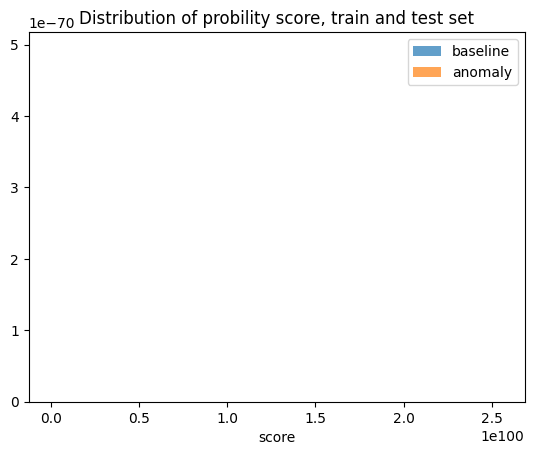

In [71]:
fixed_markov = FixedMarkovianBased(max_depth=3)
fixed_markov.train(baseline_train)

train_proba = fixed_markov.predict_proba(baseline_validation)
test_proba = fixed_markov.predict_proba(anomaly_sample)
test_proba = [elt for elt in test_proba if elt != float("inf")]

plot_distribution(train_proba, test_proba)

## Variable Markov

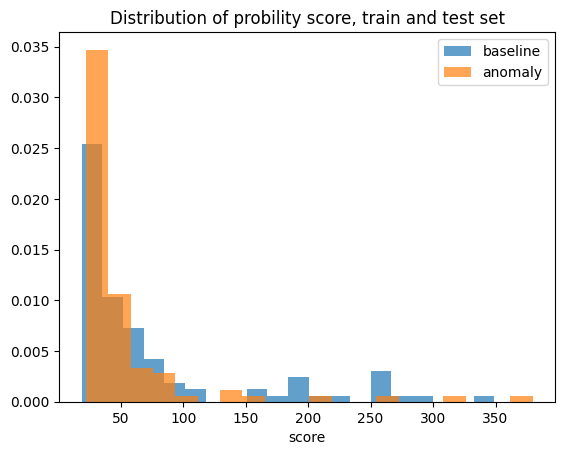

In [72]:
variable_markov = VariableMarkovianBased(max_depth=10)
variable_markov.train(baseline_train)

train_proba = variable_markov.predict_proba(baseline_train)
test_proba = variable_markov.predict_proba(anomaly_sample)

plot_distribution(train_proba, test_proba)